In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import cv2
import os
from os.path import isfile
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
plt.ion()

In [8]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    
# Define a function to extract features from a list of images
# Original function in "HOG Classify" slide
def extract_features(imgs, cspace='RGB', orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_size = (32, 32), hist_bins = 32, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        single_img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=False
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=False)) # feature_vec=True in original code
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=False) # feature_vec=True in original code
            single_img_features.append(hog_features)
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            single_img_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            single_img_features.append(hist_features)
        
        #features.append(np.hstack((spatial_features, hist_features, hog_features)))
        features.append(np.concatenate(single_img_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, cspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    bboxes = []
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      
            
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features, )).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append([(xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                # Add new box to list of bounding boxes. Each "box" takes the form ((x1, y1), (x2, y2))
    return draw_img, bboxes
    

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def show_tracked_vehicles(image_in):

    #dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

    #svc = #LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0)
    #X_scaler = StandardScaler(copy=True, with_mean=True, with_std=True) #dist_pickle["scaler"]
    #orient = 9 #dist_pickle["orient"]
    #pix_per_cell = 8 #dist_pickle["pix_per_cell"]
    #cell_per_block = 2 #dist_pickle["cell_per_block"]
    #spatial_size = (32, 32) #dist_pickle["spatial_size"]
    #hist_bins = 32 #dist_pickle["hist_bins"]
    #colorspace = 'YCrCb'

    ystart = 400
    ystop = 550
    scale = 1

    img_temp, bbox_list_1 = find_cars(image_in, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    #print("type(bboxes)", type(bbox_list))
    #print("bboxes[0]", bbox_list[0])
    
    ystart = 400
    ystop = 656
    scale = 1.5
    img_temp, bbox_list_2 = find_cars(image_in, colorspace, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image_in[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox_list_1)
    heat = add_heat(heat,bbox_list_2)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    image_out = draw_labeled_bboxes(np.copy(image_in), labels)

    return image_out, heatmap

In [4]:
# Save filenames for car and non-car images

# Divide up into cars and notcars
car_filenames = []
notcar_filenames = []
cars_dir = "./vehicles/"
not_cars_dir = "./non-vehicles/"

for root, dirs, files in os.walk(cars_dir):
    #print("root", root)
    #print("dirs", dirs)
    #print("files", files)
    for file_name in files:
        filename, file_extension = os.path.splitext(file_name)
        #print("file_extension", file_extension)
        
        if file_extension == '.png':
            full_filename = root + "/" + file_name
            #print("full_filename", full_filename)
            car_filenames.append(full_filename)
        
for root, dirs, files in os.walk(not_cars_dir):
    #print("root", root)
    #print("dirs", dirs)
    #print("files", files)
    for file_name in files:
        filename, file_extension = os.path.splitext(file_name)
        #print("file_extension", file_extension)
        
        if file_extension == '.png':
            full_filename = root + "/" + file_name
            #print("full_filename", full_filename)
            notcar_filenames.append(full_filename)
            
            
#print(car_filenames)
#print("\n")
##print(notcar_filenames)

#images = glob.glob('vehicles/*.jpeg')
#cars = []
#notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)

print("Done loading training filenames")
print("Number of car images: ", len(car_filenames))
print("Number of non-car images: ", len(notcar_filenames))


Done loading training filenames
Number of car images:  8792
Number of non-car images:  8968


In [5]:
# Extract features from car and non-car images
# Create a training and test dataset from extracted features

# Reduce the sample size because HOG features are slow to compute
#sample_size = 2000
#car_filenames = car_filenames[0:sample_size]
#notcar_filenames = notcar_filenames[0:sample_size]

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)
hist_bins = 32
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
car_features = extract_features(car_filenames, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size, hist_bins = hist_bins, 
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
notcar_features = extract_features(notcar_filenames, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size = spatial_size, hist_bins = hist_bins, 
                        spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Train Classifier

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


177.42 Seconds to extract features...


In [6]:
# Create and train SVM classifier

if not isfile('svc_pickle.p'):
    print('Training Classifier')
    print('Using:', orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    dist_pickle["colorspace"] = colorspace
    dist_pickle["spatial_feat"] = spatial_feat
    dist_pickle["hist_feat"] = hist_feat
    dist_pickle["hog_feat"] = hog_feat

    #pickle data and save
    print('Saving classfier parameters to svc_pickle.p')
    pickle.dump(dist_pickle, open( "svc_pickle.p", "wb" ) )
else:
    print("Retrieving pickled classifier parameters")
    
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    colorspace = dist_pickle["colorspace"]
    spatial_feat = dist_pickle["spatial_feat"]
    hist_feat = dist_pickle["hist_feat"]
    hog_feat = dist_pickle["hog_feat"]
    
    print("Done retrieving pickled classifier parameters")

Training Classifier
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
26.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
My SVC predicts:  [ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 1.  0.  1.  0.  0.  1.  1.  0.  1.  0.]
0.312 Seconds to predict 10 labels with SVC
Saving classfier parameters to svc_pickle.p


In [ ]:
# Manually test classifier

features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
prediction = svc.predict(test_features)


type(bboxes) <class 'list'>
bboxes[0] [(832, 400), (896, 464)]


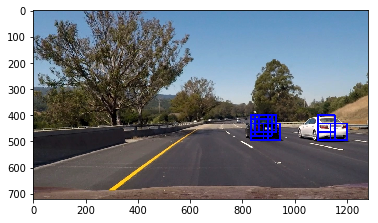

In [14]:
# Test find_cars() function
#orient = 9 #dist_pickle["orient"]
#pix_per_cell = 8 #dist_pickle["pix_per_cell"]
#cell_per_block = 2 #dist_pickle["cell_per_block"]
#spatial_size = (32, 32) #dist_pickle["spatial_size"]
#hist_bins = 32 #dist_pickle["hist_bins"]

ystart = 400
ystop = 656
scale = 1

img = mpimg.imread('test_images/test6.jpg')

out_img, bbox_list = find_cars(img, 'YCrCb', ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print("type(bboxes)", type(bbox_list))
print("bboxes[0]", bbox_list[0])

plt.imshow(out_img)

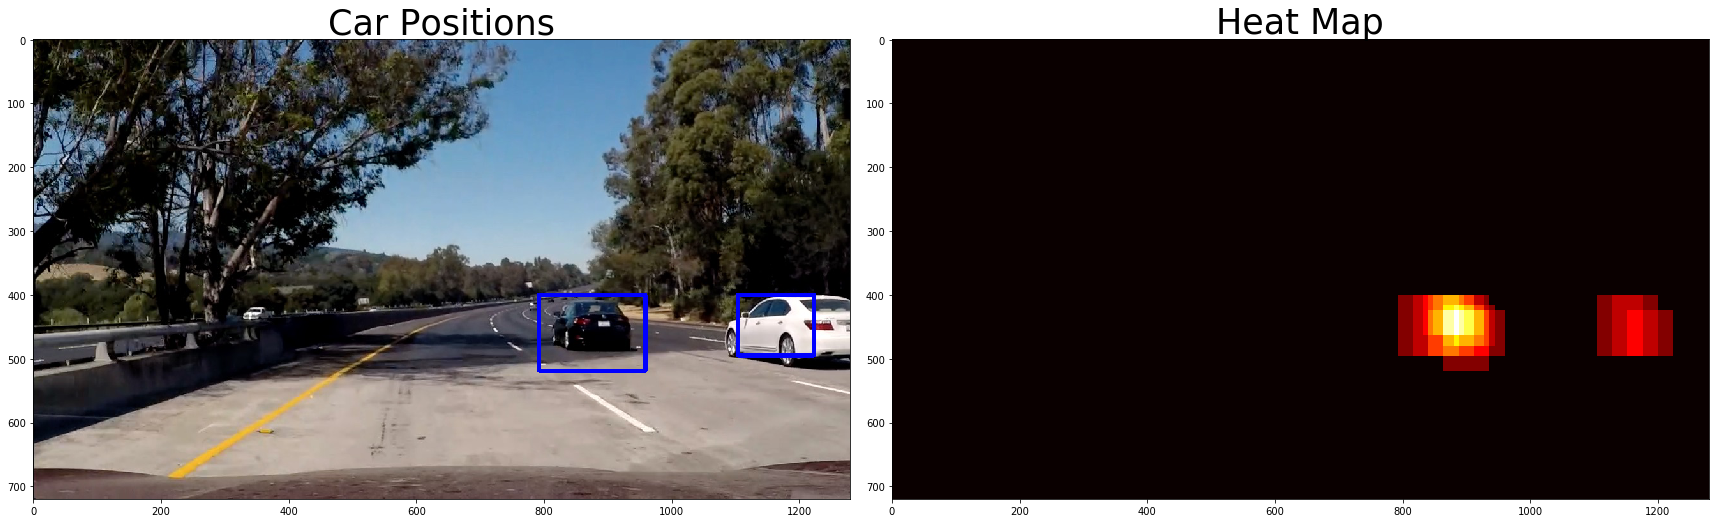

In [17]:
# Test show_tracked_vehicles() function

#%matplotlib inline
#plt.ion()

img = mpimg.imread('test_images/test5.jpg')

out_img, heatmap = show_tracked_vehicles(img)
    
#print("type(bboxes)", type(bbox_list))
#print("bboxes[0]", bbox_list[0])

'''
fig = plt.figure()
plt.subplot(121, figsize=(24, 9))
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122, figsize=(24, 9))
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
'''

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Car Positions', fontsize=35)

ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=35)


In [41]:
def process_image(image):
    
    result, heatmap = show_tracked_vehicles(np.copy(image))
    #result = np.copy(image)
    
    return result

In [42]:

input_filename = "project_video.mp4" #"test_video.mp4"
output_filename = 'project_video_output.mp4' #'test_video_output.mp4'
clip1 = VideoFileClip(input_filename)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_filename, audio=False)



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████▉| 1260/1261 [35:26<00:01,  1.66s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 35min 29s


In [11]:
# Create some test images of my own

filename = 'test_images/my_test_7.jpg'
clip = VideoFileClip("project_video.mp4")

clip.save_frame(filename, t=24.6, withmask=True)


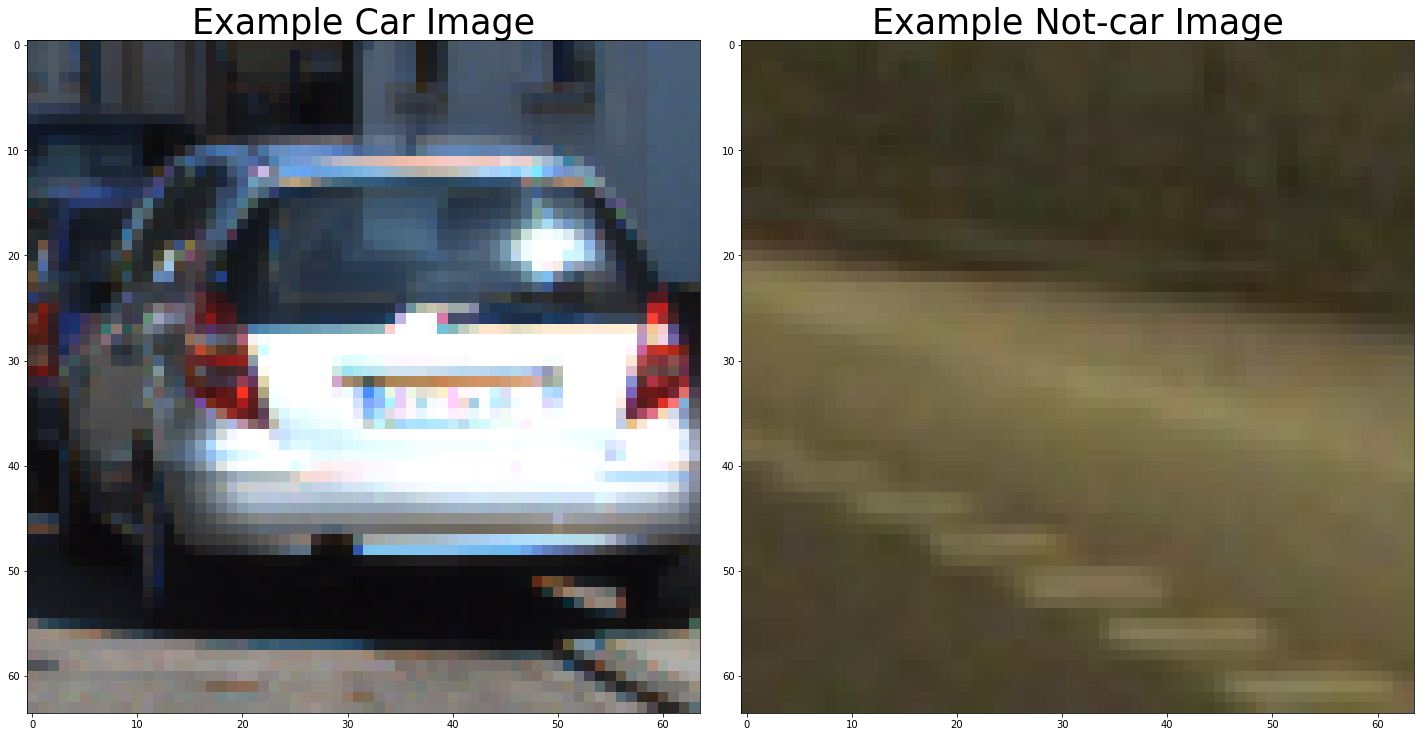

In [28]:
# Read in a vehicle image and a non-vehicle image and display them

car_ind = np.random.randint(0, len(car_filenames))
notcar_ind = np.random.randint(0, len(notcar_filenames))
    
# Read in car / not-car images
random_car_image = mpimg.imread(car_filenames[car_ind])
random_notcar_image = mpimg.imread(notcar_filenames[notcar_ind])


# Plot the examples
'''
fig = plt.figure()
plt.subplot(121)
plt.imshow(random_car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(random_notcar_image)
plt.title('Example Not-car Image')

'''
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f.tight_layout()
ax1.imshow(random_car_image)
ax1.set_title('Example Car Image', fontsize=35)

ax2.imshow(random_notcar_image)
ax2.set_title('Example Not-car Image', fontsize=35)


In [ ]:



practice_colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
practice_orient = 9
practice_pix_per_cell = 8
practice_cell_per_block = 2
practice_hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
practice_spatial_size = (32, 32)
practice_hist_bins = 32
practice_spatial_feat=True
practice_hist_feat=True
practice_hog_feat=True

    
practice_img_converted = cv2.cvtColor(practice_img, cv2.COLOR_RGB2YCrCb)
    
ch1 = practice_img_converted[:,:,0]
ch2 = practice_img_converted[:,:,1]
ch3 = practice_img_converted[:,:,2]
    
# Compute individual channel HOG features for the entire image
hog1 = get_hog_features(ch1, practice_orient, practice_pix_per_cell, practice_cell_per_block, vis=True, feature_vec=False)
hog2 = get_hog_features(ch2, practice_orient, practice_pix_per_cell, practice_cell_per_block, vis=True, feature_vec=False)
hog3 = get_hog_features(ch3, practice_orient, practice_pix_per_cell, practice_cell_per_block, vis=True, feature_vec=False)